In [ ]:
import torch

In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os

In [ ]:
# transforms
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]),

    'test': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
}

Normalize does the following for each channel:

image = (image - mean) / std

The parameters mean, std are passed as 0.5, 0.5 in your case. This will normalize the image in the range [-1,1]. For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.

if you would like to get your image back in [0,1] range, you could use,

image = ((image * std) + mean)

Resize image because: convolutional neural networks expect inputs with the same size.

transforms.RandomHorizontalFlip() is an image transformation provided by PyTorch's torchvision library. It performs a random horizontal flip of the input image with a probability of 0.5. This can help to augment the training data and prevent overfitting by providing the model with a diverse set of inputs.

In [ ]:
# import data
data_dir = '/content/drive/MyDrive/chest_xray'
sets = ['train','test']
image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                  for x in ['train', 'test']}    

In [ ]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 5216
     Root location: /content/drive/MyDrive/chest_xray/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 624
     Root location: /content/drive/MyDrive/chest_xray/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            )}

In [ ]:
train_dataset = image_datasets['train']
test_dataset = image_datasets['test']

In [ ]:
feature, label = train_dataset[0]
feature.shape

torch.Size([3, 224, 224])

1858x2090 image with 3 channels resized into 224x224 with 3 channels

In [ ]:
class_names = image_datasets['train'].classes
class_names

['NORMAL', 'PNEUMONIA']

2 classes either NORMAL or PNEUMONIA

In [ ]:
# create DataLoader object
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 4,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size = 4,
                                           shuffle=False)

In [ ]:
train_loader

In [ ]:
# example
example = iter(train_loader)
example

In [ ]:
samples, target = next(example)
samples.shape

torch.Size([4, 3, 224, 224])

4 <-- batch_size = 4

In [ ]:
samples

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -0.5922, -0.6392, -0.6627],
          [-1.0000, -1.0000, -1.0000,  ..., -0.5216, -0.4980, -0.4745],
          [-1.0000, -1.0000, -1.0000,  ..., -0.7725, -0.7098, -0.6157],
          ...,
          [-0.9451, -0.9529, -0.9529,  ..., -0.7725, -0.7490, -0.7255],
          [-0.9451, -0.9451, -0.9451,  ..., -0.7804, -0.7569, -0.7255],
          [-0.9451, -0.9451, -0.9451,  ..., -0.7804, -0.7569, -0.7255]],

         [[-1.0000, -1.0000, -1.0000,  ..., -0.5922, -0.6392, -0.6627],
          [-1.0000, -1.0000, -1.0000,  ..., -0.5216, -0.4980, -0.4745],
          [-1.0000, -1.0000, -1.0000,  ..., -0.7725, -0.7098, -0.6157],
          ...,
          [-0.9451, -0.9529, -0.9529,  ..., -0.7725, -0.7490, -0.7255],
          [-0.9451, -0.9451, -0.9451,  ..., -0.7804, -0.7569, -0.7255],
          [-0.9451, -0.9451, -0.9451,  ..., -0.7804, -0.7569, -0.7255]],

         [[-1.0000, -1.0000, -1.0000,  ..., -0.5922, -0.6392, -0.6627],
          [-1.0000, -1.0000, -

In [ ]:
target

tensor([1, 1, 1, 0])

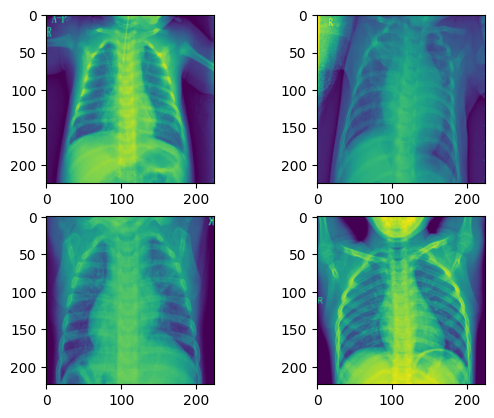

In [ ]:
# plot all image of batch
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(samples[i][0])
plt.show()

### Implement CNN (LeNet-5)
 It consists of two convolutional layers, each followed by a subsampling layer, and then three fully connected linear layers.

In [ ]:
class simpleCNN(nn.Module):
  def __init__(self):
    super(simpleCNN,self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3,
                           out_channels=6,
                           kernel_size=5) #size [4,6,220,220]
    
    self.pool1 = nn.MaxPool2d(2,2) #size [4, 6, 110, 110]
    
    self.conv2 = nn.Conv2d(in_channels=6,
                           out_channels=16,
                           kernel_size=5) #size [4,16,106,106]
    
    self.pool2 = nn.MaxPool2d(2,2) #size [4, 16, 53, 53]

    ##fully connected layer##
    self.fc1 = nn.Linear(16*53*53, 120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,2)

  def forward(self, x):
    #CNN
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))

    #flatten
    x = x.view(-1, 16*53*53)

    # fc layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x


In [ ]:
# create model
model = simpleCNN()

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
len(train_loader) #no. of iteration

1304

In [ ]:
# training loop
total_batches = len(train_loader)

for epoch in range(10):
    for i , (images, labels) in enumerate(train_loader):
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 400 == 0:
            print(f'Epoch [{epoch+1}/{4}], step [{i+1}/{total_batches}], loss:{loss.item():.4f}')
            
print('Finished Training')

Epoch [1/10], step [400/1304], loss:0.0446
Epoch [1/10], step [800/1304], loss:0.1141
Epoch [1/10], step [1200/1304], loss:0.2400
Epoch [2/10], step [400/1304], loss:0.0016
Epoch [2/10], step [800/1304], loss:0.0013
Epoch [2/10], step [1200/1304], loss:0.1064
Epoch [3/10], step [400/1304], loss:1.3230
Epoch [3/10], step [800/1304], loss:1.0034
Epoch [3/10], step [1200/1304], loss:0.1022
Epoch [4/10], step [400/1304], loss:0.6063
Epoch [4/10], step [800/1304], loss:0.0006
Epoch [4/10], step [1200/1304], loss:0.0005
Epoch [5/10], step [400/1304], loss:0.7789
Epoch [5/10], step [800/1304], loss:0.0022
Epoch [5/10], step [1200/1304], loss:0.0367
Epoch [6/10], step [400/1304], loss:0.0029
Epoch [6/10], step [800/1304], loss:0.0097
Epoch [6/10], step [1200/1304], loss:0.0006
Epoch [7/10], step [400/1304], loss:0.0000
Epoch [7/10], step [800/1304], loss:0.0000
Epoch [7/10], step [1200/1304], loss:0.0006
Epoch [8/10], step [400/1304], loss:0.0107
Epoch [8/10], step [800/1304], loss:0.0000
Epoc

In [ ]:
# testing and evaluation
with torch.no_grad():
    n_correct =0
    n_samples =0
    
    for images, labels in test_loader:
        # forward -- softmax prediction 
        outputs = model(images)
        
        # actual prediction
        # value, index
        _, predictions = torch.max(outputs, 1) # multiclass pred
        n_samples += labels.shape[0]
        n_correct += (predictions==labels).sum().item()
        
    acc = 100.0 * n_correct / n_samples
    print(acc)

71.15384615384616


In [ ]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
         MaxPool2d-2          [-1, 6, 110, 110]               0
            Conv2d-3         [-1, 16, 106, 106]           2,416
         MaxPool2d-4           [-1, 16, 53, 53]               0
            Linear-5                  [-1, 120]       5,393,400
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 5,406,606
Trainable params: 5,406,606
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.49
Params size (MB): 20.62
Estimated Total Size (MB): 25.68
----------------------------------------------------------------


In [ ]:
torch.save(model.state_dict(), 'model.pth')